# Part 2 - Clusters

In this part, we will first display maps representing the accidents, then we'll perform various clusterizations.

## Data filtering

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Import the four csv files that we are going to use
df1 = pd.read_csv("./data/caracteristics.csv", encoding='latin-1')
df2 = pd.read_csv("./data/places.csv")
df3 = pd.read_csv("./data/users.csv")
df4 = pd.read_csv("./data/vehicles.csv")

# Merge all the dataframes together using the column 'Num_Acc' that they have in common
df1 = pd.merge(df1, df2, how="outer", on="Num_Acc")
df2 = pd.merge(df3, df4, how='outer', on="Num_Acc")

data = pd.merge(df1, df2, how='outer', on="Num_Acc")

In [3]:
# Select the columns that we want to keep and we rename it appropriately
columns = ['an', 'mois', 'grav', 'lat', 'long']

data = data[columns]
data.columns = ['Year', 'Month', 'Severity', 'Latitude', 'Longitude']

# Delete all rows for which we have no information about location
data.dropna(axis=0, subset=['Latitude', 'Longitude'], inplace=True)

# Rearrange the 'Severity' numbers in ascending order
data['Severity'].replace({2: 4, 4: 2}, inplace=True)

# Create a dictionary with a description for each level of severity
severity_description = {
    1: "Unscathed",
    2: "Light injury",
    3: "Hospitalized wounded",
    4: "Killed"
}

data

,Year,Month,Severity,Latitude,Longitude
0,16,2,1,0.0,0.0
1,16,2,1,0.0,0.0
2,16,2,3,0.0,0.0
3,16,2,3,0.0,0.0
4,16,3,3,0.0,0.0
...,...,...,...,...,...
3552260,5,12,1,0.0,0.0
3552261,5,12,3,0.0,0.0
3552262,5,12,3,0.0,0.0
3552263,5,12,3,0.0,0.0


In [4]:
import numpy as np
import seaborn as sns

# Replace wrong characters with '0' and convert it to double
data['Longitude'] = data['Longitude'].replace('-', 0).astype('double')
data['Latitude'] = data['Latitude'].replace('-', 0).astype('double')

# Keep only the accidents located in mainland france
data = data.loc[(data['Longitude'] < 3*10**6) & (data['Latitude'] > 3*10**6) & (data['Latitude'] < 5.2*10**6)]

## 1 - Maps

Let's first display in simple map of the all the accidents between 2005 and 2016:

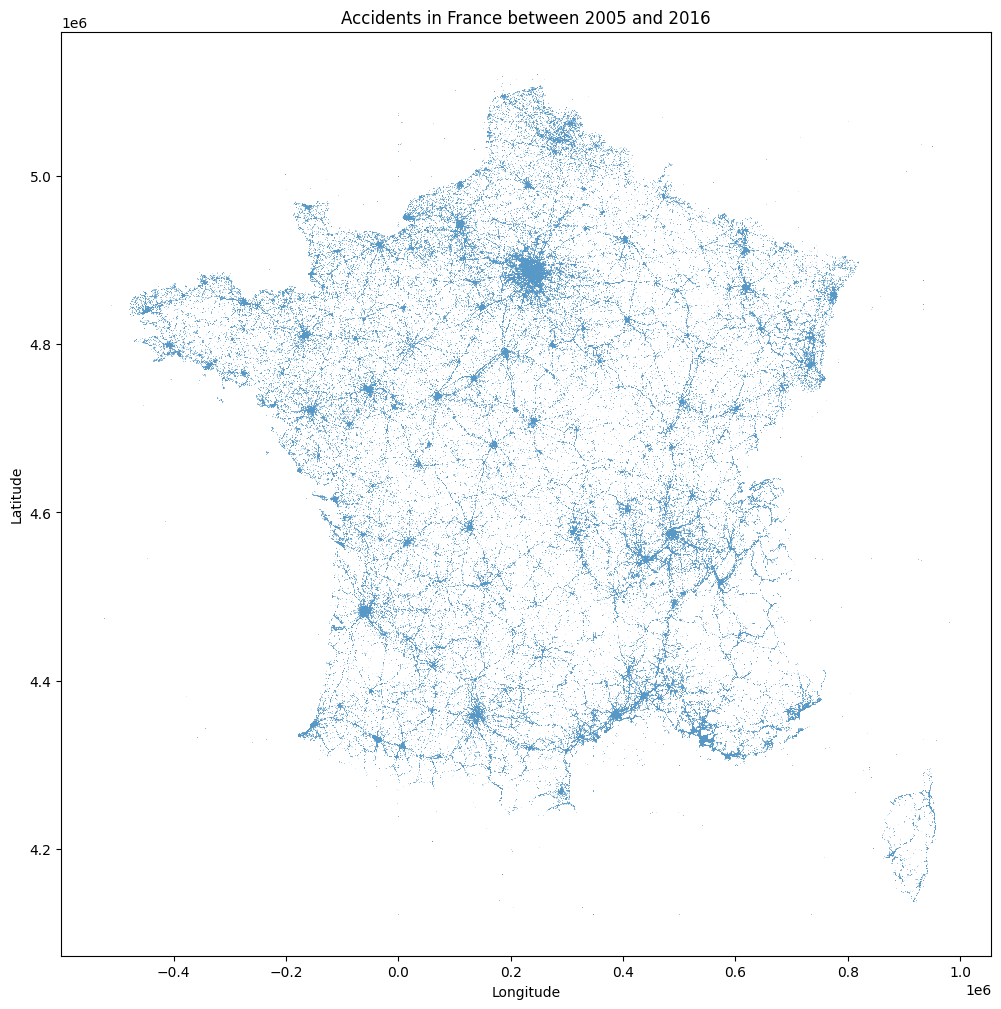

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
sns.scatterplot(data=data, x='Longitude', y='Latitude', s=0.1)
plt.title("Accidents in France between 2005 and 2016")
plt.show()

Now, let's display a different map for each severity coefficient. This way, we will see if the accidents' location is different according to the severity.

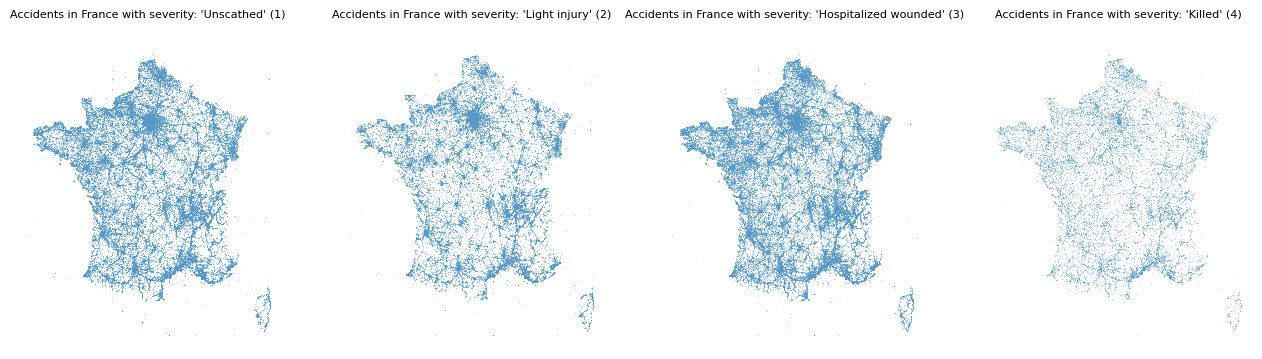

In [10]:
plt.figure(figsize=(16,4))

for i in range(1, 5):
    plt.subplot(1, 4, i)
    sns.scatterplot(data=data.loc[data['Severity']==i], x='Longitude', y='Latitude', s=0.1)
    plt.axis(False)
    plt.title(f"Accidents in France with severity: '{severity_description[i]}' ({i})", fontsize=8)
plt.show()

We observe that the location is not linked to the severity: accidents both severe and non-severe accidents occur in cities and on roads.

Let's try to display a map of the accidents for each year between 2005 and 2016. This way, we will see if the accidents' locations change over years.

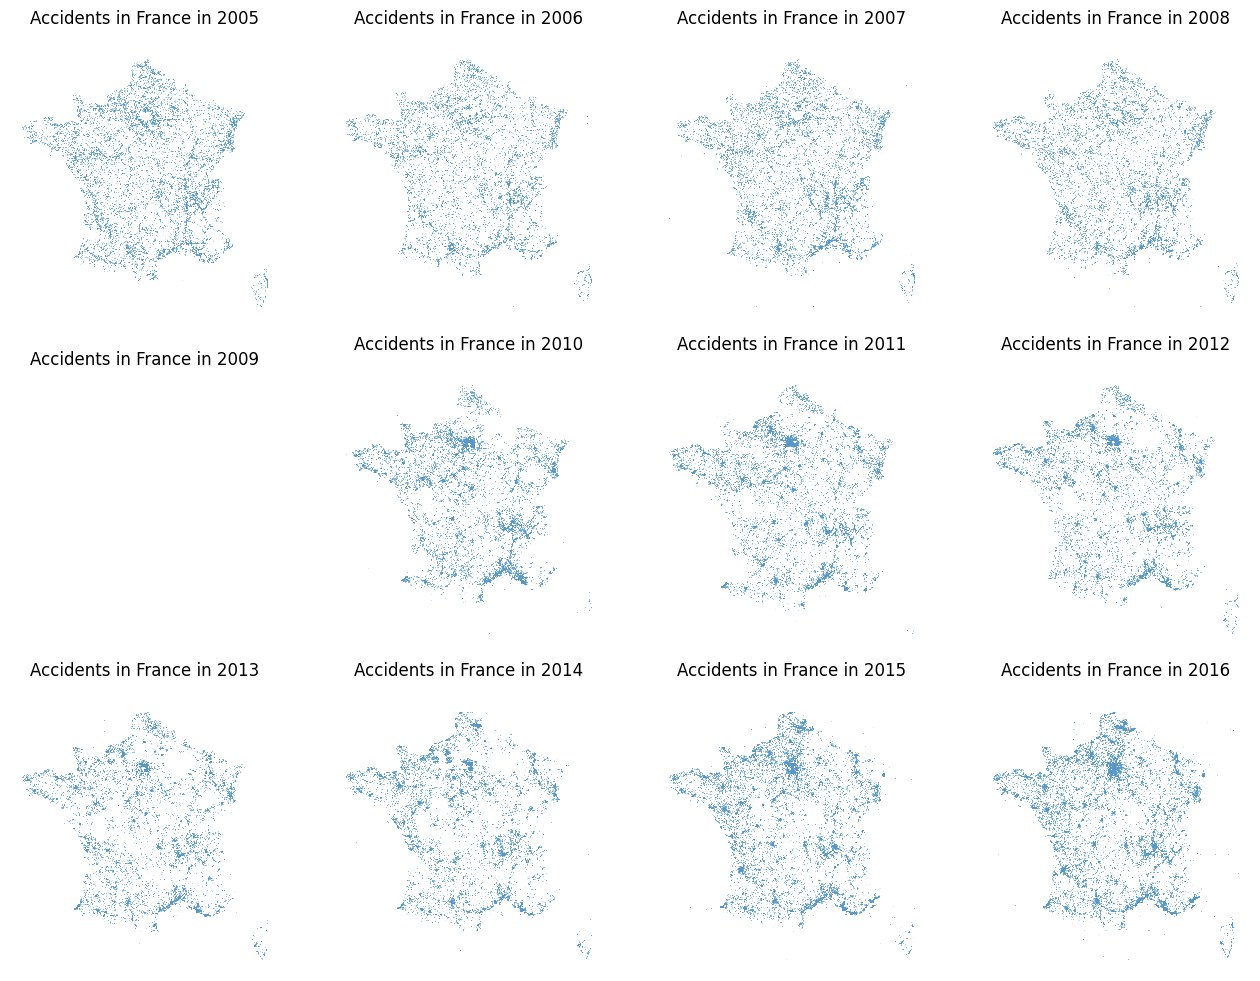

In [12]:
plt.figure(figsize=(16,12))

for i in range(1, 13):
    plt.subplot(3, 4, i)
    sns.scatterplot(data=data.loc[data['Year']==4+i], x='Longitude', y='Latitude', s=0.1)
    plt.axis(False)
    plt.title(f"Accidents in France in {2004 + i}")
plt.show()

At first glance, we can think that there are more accidents in the cities over years, but we have to be careful about the fact that we have not the same amount of data per year. For example, the 2009's accidents have no information about location so we have no map. Therefore, the fact that there are more accidents in the cities is maybe due to the fact that we have more data in the most recent years.

In any case, we can note from the previous two blocks of code that the accidents are grouped around France's biggest cities. We will try to confirm this hypothesis thanks to clusters.

## 2 - Clusters

To verify our hypothesis, we will first use KMeans clusterization method to divide the accidents into 15 clusters. In addition to that, we will plot on the map the 22 french metropolises. 

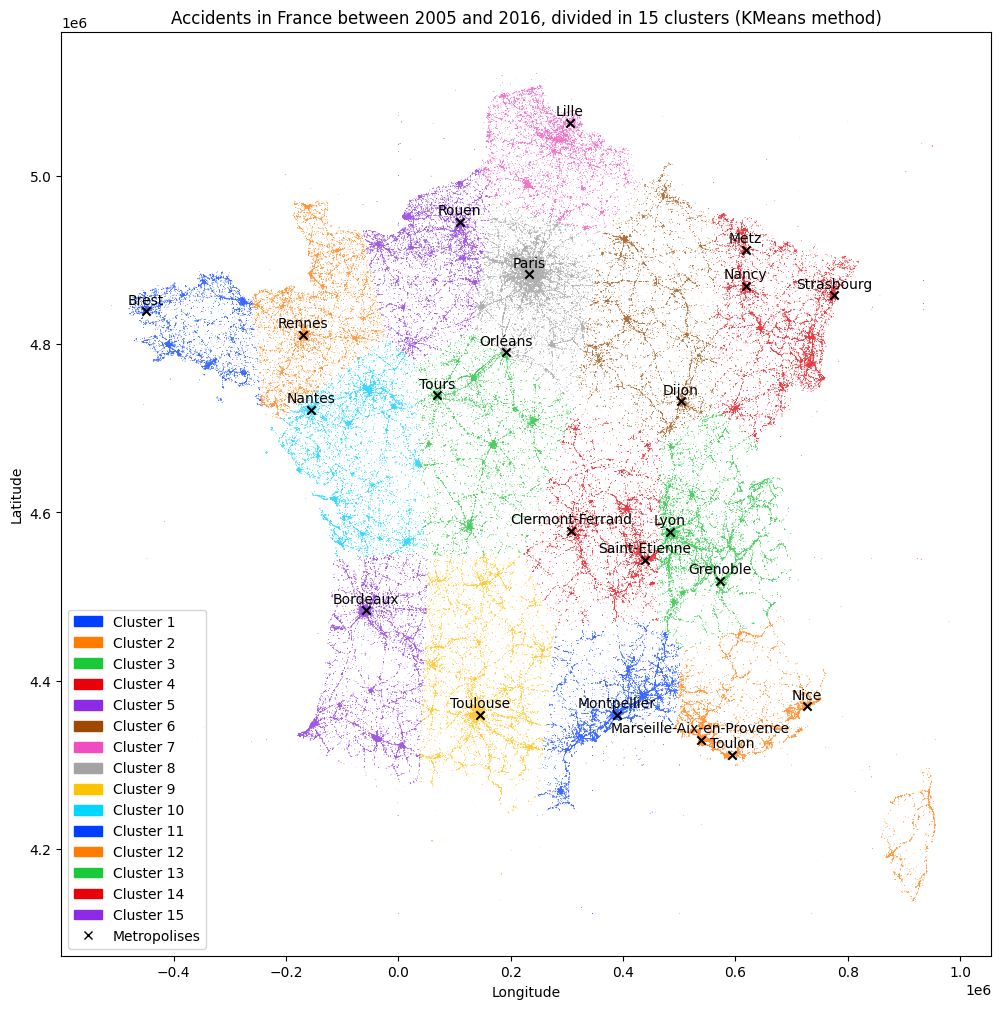

In [13]:
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

n_clusters = 15

# Perform KMeans clusterization
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(data[['Longitude', 'Latitude']])
labels = kmeans.labels_

# Create a figure and plot all the accidents with different colors according to the different clusters
plt.figure(figsize=(12,12))
sns.scatterplot(data=data, x="Longitude", y="Latitude", hue=labels, palette=sns.color_palette("bright", n_clusters), s=0.1)

# Define the longitude and latitude of the 22 french metropolises
metropolises_coordinates = {
    "Paris" : (2.33*10**5, 48.83*10**5),
    "Lille" : (3.05*10**5, 50.63*10**5),
    "Rouen" : (1.09*10**5, 49.45*10**5),
    "Metz" : (6.18*10**5, 49.12*10**5),
    "Nancy" : (6.18*10**5, 48.69*10**5),
    "Strasbourg" : (7.75*10**5, 48.58*10**5),
    "Brest" : (-4.49*10**5, 48.39*10**5),
    "Rennes" : (-1.69*10**5, 48.11*10**5),
    "Nantes" : (-1.56*10**5, 47.22*10**5),
    "Tours" : (0.69*10**5, 47.39*10**5),
    "Orléans" : (1.92*10**5, 47.90*10**5),
    "Dijon"  : (5.03*10**5, 47.32*10**5),
    "Clermont-Ferrand" : (3.08*10**5, 45.78*10**5),
    "Lyon" : (4.83*10**5, 45.77*10**5),
    "Saint-Etienne" : (4.39*10**5, 45.44*10**5),
    "Grenoble" : (5.73*10**5, 45.19*10**5),
    "Bordeaux" : (-0.58*10**5, 44.84*10**5),
    "Toulouse" : (1.45*10**5, 43.60*10**5),
    "Montpellier" : (3.89*10**5, 43.60*10**5),
    "Marseille-Aix-en-Provence" : (5.38*10**5, 43.30*10**5),
    "Toulon" : (5.94*10**5, 43.12*10**5),
    "Nice" : (7.27*10**5, 43.70*10**5)
}

# Add the metropolises to the plot
for city in metropolises_coordinates:
    plt.scatter(metropolises_coordinates[city][0], metropolises_coordinates[city][1], marker='x', color='black')
    plt.text(metropolises_coordinates[city][0], metropolises_coordinates[city][1] + 0.05*10**5, s=city, ha='center', va='bottom')

# Define the plot's legend
legend = []
for i, color in enumerate(sns.color_palette("bright", n_clusters)):
    legend.append(mpatches.Patch(color=color, label=f"Cluster {i + 1}"))

cross = Line2D([0], [0], label='Metropolises', marker='x', markeredgecolor='black', linestyle='')
legend.append(cross)

# Add the legend and show the result
plt.legend(handles=legend, loc='lower left')
plt.title(f"Accidents in France between 2005 and 2016, divided in {n_clusters} clusters (KMeans method)")
plt.show()

Here, we clearly see that the accidents are grouped around the different metropolises. However, as we didn't know what number of clusters was optimal, we chose 15 arbitrary. Indeed, the KMeans method needs the number of clusters as input to work. To be more rigorous, we can chose a method that determines by itself the optimal number of clusters, such as the DBSCAN method.

The DBSCAN uses different parameters than the KMeans method. The two main parameters are epsilon (`eps`) and the minimum samples (`min_samples`). The epsilon correspond to the maximum distance between two points for them to be considered part of the same cluster. The minimum samples value is the minimum number of points that are needed to form a cluster. As we want the clusters to be cities, we fix it to 300 points.

To find the optimal epsilon value, we use the method described in [this article](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf). First we use the NearestNeighbors class to calculate the average distance between each point in the dataset and its nearest neighbors. Then, we sort it in ascending order and we plot it. The ideal value will be equal to the distance value at the “crook of the elbow”, or the point of maximum curvature. This is what we do here:

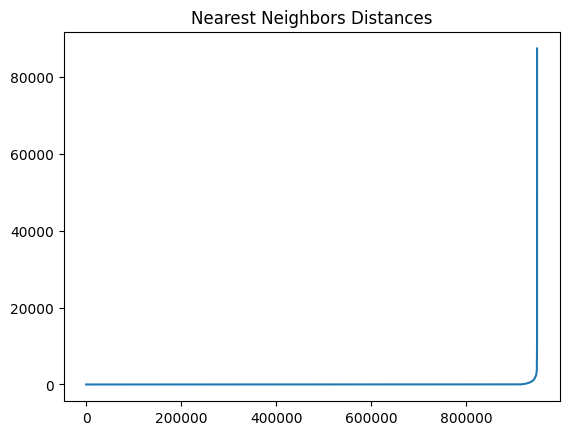

In [18]:
from sklearn.neighbors import NearestNeighbors

# Calculate the distance between each point and its nearest neighbors
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(data[['Longitude', 'Latitude']])
distances, indices = neighbors_fit.kneighbors(data[['Longitude', 'Latitude']])

# Sort it in ascending order
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Plot the distances
plt.figure()
plt.plot(distances, label='Distances')
plt.title("Nearest Neighbors Distances")
plt.show()

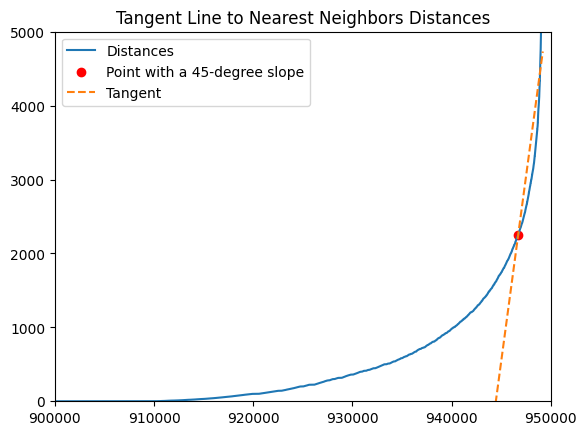

Optimal Epsilon value: 2249.2380932217916


In [17]:
# Plot the distances
plt.figure()
plt.plot(distances, label='Distances')

# We find the point of maximum curvature and calculate the tangent
point_index = np.argmin(np.abs(np.gradient(distances) - 1))
tangent_line = np.arange(len(distances)) - (point_index - distances[point_index])

# We plot the point and the tangent
plt.scatter(point_index, distances[point_index], color='red', label='Point with a 45-degree slope')
plt.plot(tangent_line, label=f'Tangent', linestyle='--')

# Zoom on the crook of the elbow
plt.legend()
plt.axis([900000, 950000, 0, 5000])
plt.title("Tangent Line to Nearest Neighbors Distances")
plt.show()

# Print the espilon value found
print(f"Optimal Epsilon value: {distances[point_index]}")

Now that we have the optimal epsilon value, we can apply the DBSCAN method:

In [26]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

# Perform DBBSCAN clusterization method
db = DBSCAN(eps=2250, min_samples=300).fit(data[['Longitude', 'Latitude']])
labels = db.labels_

# Count and print the number of clusters
n_clusters = len(set(labels)) - 1
print(f"{n_clusters} clusters found.")

153 clusters found.


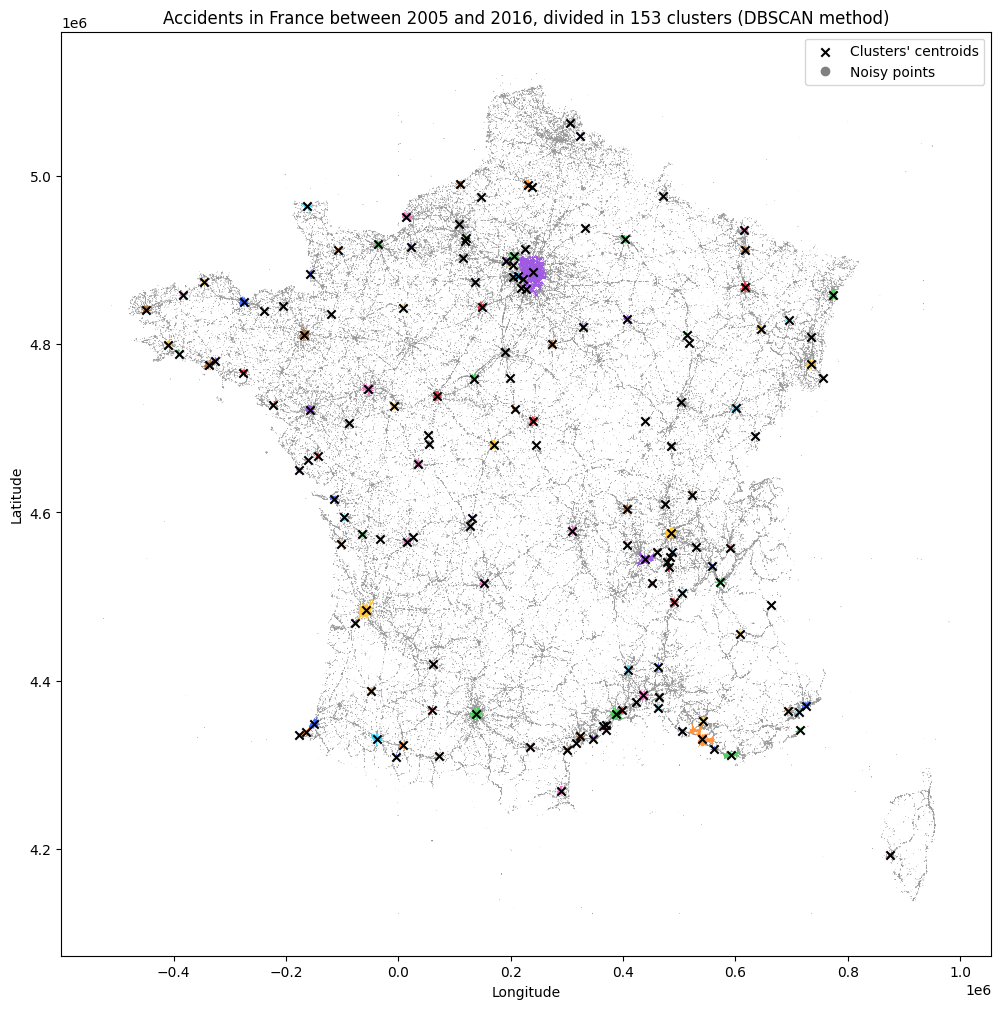

In [27]:
plt.figure(figsize=(12, 12))

# Create a custom palette where each cluster have a bright color, and unclassified points are gray
custom_palette = {}
palette = sns.color_palette('bright', n_clusters)

k=0
for cluster in set(labels):
    if cluster != -1:
        custom_palette[cluster] = palette[k]
        k+=1
    else:
        custom_palette[cluster] = (0.5, 0.5, 0.5)

# Create a column 'Cluster' with the corresponding cluster for each point
data['Cluster'] = labels

# Plot all the accidents with different colors using the custom palette
scatter = sns.scatterplot(data=data, x="Longitude", y="Latitude", hue='Cluster', palette=custom_palette, s=0.1, legend=None)

# Plot a marker on the centroids of each cluster
centroids = data.groupby('Cluster')[['Longitude', 'Latitude']].mean()
plt.scatter(centroids['Longitude'], centroids['Latitude'], marker='x', color='black', label="Clusters' centroids")

# Add noisy points to the figure's legend
legend, _ = scatter.get_legend_handles_labels()
point = Line2D([0], [0], label='Noisy points', marker='o', markerfacecolor='gray', markeredgecolor='gray', linestyle='')
legend.append(point)

# Show the legend and display the figure
plt.legend(handles=legend, loc='upper right')
plt.title(f"Accidents in France between 2005 and 2016, divided in {n_clusters} clusters (DBSCAN method)")
plt.show()

This map confirms our hypothesis: the clusters' centroid are located on the biggest french cities so this is where most accidents occur, particularly around Paris and on the mediterranean coast.